# Determining $r$, the scale ratio

## Determining $r_\min$

Minimal $r$ value is determined by the sampling rate and $T$. There is no "natural" plateau -- the plateau is caused by resolution saturation of the sampling rate. This occurs at $r_\min = 1/\pi f_s T$, i.e., when the expected number of zero crossings on the sampling interval $\Delta t = 1/f_s$ is equal to one.

Leftmost limit is $E(N_\ell)/T \rightarrow \text{const.}$ [because it goes into the unconstrained RBF, such that $E(N_\ell) = 1/\pi \ell$, i.e., twice the upcrossing rate], rightmost limit is $E(N_\ell) \rightarrow 1$ [because of the constraint]

- The necessary $r = 1/\pi \approx 0.32$ at which the expected number of zeros ($E[N_\ell] = 2T E[N_u]$ = twice the expected number of level-zero upcrossings $E[N_u] = (2\pi\ell)^{-1}$ on $[0,1]$, as defined in R&W) crossings on $[0,T]$ is equal to one for the unconstrained RBF is still a good reference for the constrained RBF. Therefore an easy guess for $r$ is given by the theoretical value for the unconstrained RBF kernel: $r^* = 1/\pi$.
- The two constraints only influence zero crossings for appreciable lengthscales, as expected, and keep $E(N_\ell)$ at one, rather than it decaying to zero, as with the unconstrained RBF

## Determining $r_\max$

Maximal $r$ value is determined by the integration constraint and power considerations, because we know that the expected number of zeros is always one.

Leftmost limit is $E(N_\ell)/T \rightarrow \text{const.}$ [because it goes into the unconstrained RBF, such that $E(N_\ell) = 1/\pi \ell$, i.e., twice the upcrossing rate], rightmost limit is $E(N_\ell) \rightarrow 1$ [because of the constraint]

We know that for large $r$ the norm of the kernel matrix of the constrained RBF decays exponentially, while qualitatively the samples converge to a fixed shape, with smaller and smaller amplitude, and thus smaller and smaller power on $[0,T]$. But what is a good crossover point?

The maximum value of $r$ we take is that the expected power on $[0,T]$ of $u(t)$, *assuming unit marginal variance $\sigma^2$*, is comparable to the expected power of the noise, which is at -20 dB or below (in the best case about 40 dB). In this case $r$ is so large that $u(t)$ is indistinguishable from noise. Because of normalization and the fact that $u(t)$ is "at the signal level" (see `map.md`), we know that $\sigma^2 \approx 1$, and at worst $\sigma \sim 0.1$, so $\sigma^2 = -20 dB$, so we can treshold at -60 dB6 to find $r_\max$.

*More details:*

Maximal $r$ value: we simply take $r_\max \approx 2$, based on the expected number of zero crossings below and amplitude decay. Why?
- We know that from a certain $r>1$, $k_u(r)$ (and also $k(r)$ in fact) begin to degenerate into all-ones matrices $J_M$, and the samples of $k_u$ become identical except for their amplitude, which strongly decreases as $r$ grows (the amplitude also decreases for the unconstrained RBF kernel). But tresholding this phenomenon is quite difficult; for example, the matrices do not degenerate into scaled copies of each other (the scaling function is a quadratic), and the behavior in terms of $D_{KL}$ distance is also not obvious because of this (and in practice, the nugget terms cause a lot of confusion when calculating the $D_{KL}$). For this reason, a good high-level function on which to base the threshold of $r_\max$ is simply the expected number of zero crossings itself; and the asymptote $E(N_\ell) \rightarrow 1$ starts roughly at around $r \sim 1$.
- In Figure 7 in Riutort-Mayol (2020) it is seen that $\ell/T$ only goes up until 1.25. Thus we can conclude that lengthscales larger than the range spanned by the data make little sense anyway.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels
from dgf import exact
from dgf import constants

rng = np.random.default_rng(9198)

In [2]:
fs = constants.FS_KHZ
T = 7. # msec
N = int(T*fs) + 1
x, dx = jnp.linspace(0., T, N, retstep=True)

### The EXACT RBF kernel

array([2, 1, 2])

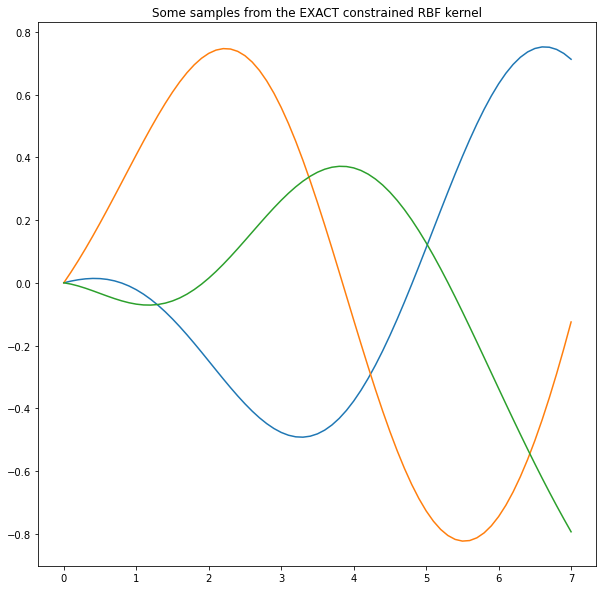

In [36]:
nugget = 1e-12

def num_zero_crossings(a, axis=-1):
    return (sum(abs(diff(sign(a), axis=axis)), axis=axis) / 2).astype(int)

def num_zero_crossings_dgf(a):
    return num_zero_crossings(a[1:,:], axis=0)

def sample_exact_dgf(r, size, nugget=nugget):
    scale = r*T
    K = exact.kernelmatrix_gfd(x[:,None], x[None,:], scale, T) + nugget*jnp.eye(len(x))
    return multivariate_normal(zeros_like(x), K, size=size, tol=nugget).T # (N, size)

a = sample_exact_dgf(1/pi, size=3)
plot(x, a)
title('Some samples from the EXACT constrained RBF kernel')
num_zero_crossings_dgf(a)

In [4]:
# Count the zero crossings in `[0,T]` for different values of `r`
Nr = 40
Nz = 10000
rs = 10**linspace(-3, 1, Nr)

z = np.vstack([
    num_zero_crossings_dgf(sample_exact_dgf(r, Nz)) for r in rs
]) # (Nr, Nz)
m = mean(z, axis=1)
sd = std(z, axis=1)

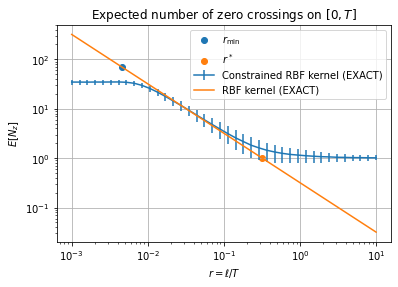

In [5]:
errorbar(rs, m, yerr=sd, label="Constrained RBF kernel (EXACT)")
errorbar(rs, 1/(pi*rs), label="RBF kernel (EXACT)")
scatter(1/(fs*T*pi), fs*T, label="$r_\min$")
scatter(1/(pi), 1., label="$r^*$")

xscale('log')
yscale('log')
legend();
grid()
title('Expected number of zero crossings on $[0,T]$')
ylabel('$E[N_z]$')
xlabel('$r = \ell/T$');

### Comparing the EXACT and HILBERT implementations of the RBF kernel

We see good performance of HILBERT until $r \approx 1$.

array([1, 1, 1])

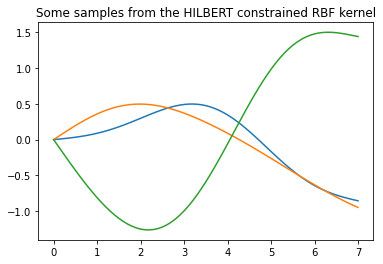

In [6]:
var = 1.
M = 128
c = 2.

def sample_hilbert_dgf(kernel_name, r, size, impose_null_integral=True):
    kernel = isokernels.resolve(kernel_name)
    scale = r*T
    
    Rhilbert = core.kernelmatrix_root_gfd(
        kernel, var, scale, x, M, T, c, impose_null_integral=impose_null_integral
    )
    
    z = randn(M, size)
    return Rhilbert @ z # (N, size)

a = sample_hilbert_dgf('SqExponentialKernel', 1/pi, 3)
plot(x, a)
title('Some samples from the HILBERT constrained RBF kernel')
num_zero_crossings_dgf(a)

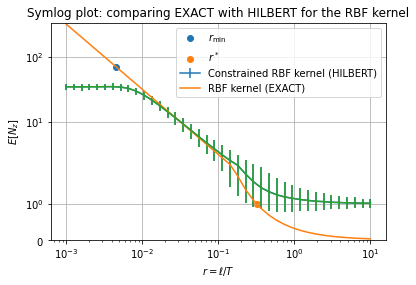

In [7]:
z = np.vstack([
    num_zero_crossings_dgf(
        sample_hilbert_dgf('SqExponentialKernel', r, Nz, impose_null_integral=True)
    ) for r in rs
]) # (Nr, Nz)

m_hilbert = mean(z, axis=1)
sd_hilbert = std(z, axis=1)

errorbar(rs, m, yerr=sd, label="Constrained RBF kernel (HILBERT)")
errorbar(rs, 1/(pi*rs), label="RBF kernel (EXACT)")
scatter(1/(fs*T*pi), fs*T, label="$r_\min$")
scatter(1/(pi), 1., label="$r^*$")

xscale('log')
yscale('symlog')
ylim(bottom=0)
legend();
grid()
title('Symlog plot: comparing EXACT with HILBERT for the RBF kernel')
ylabel('$E[N_z]$')
xlabel('$r = \ell/T$')

errorbar(rs, m, yerr=sd, label="Constrained RBF kernel (EXACT)");

At values of $r > 1$, the generated samples do not have zero crossings; they do start at the origin (GOI constraint), but do not have a zero crossing (unlike the exact RBF, whose zero crossings go to 1 instead of 0). This behavior does not depend strongly on $M$. In both exact and inexact RBF cases the amplitudes become very small rapidly.

Note: since the amplitudes are so small, the integral is in fact close to zero (around 1e-8 at the crossover point and decreasing exponentially quickly for increasing $r$ further), so the constraint fails gracefully and does not pose any problem when used in inference: the amplitudes are so unlikely small that the $N(0,1)$ prior on the amplitudes effectively prevents this situation.

Note 2: this behavior only occurs for the SqExpKernel and goes away for the Matern kernels (which are more stable).

r = 3.07029062975785
N_z: [0 0 0]
Integral (should be 0): [-5.13849147e-09 -1.64025234e-08 -4.39507215e-09]


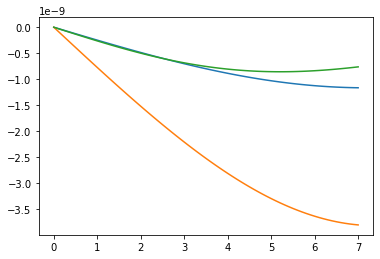

In [8]:
i = -6
print('r =', rs[-6])
a = sample_hilbert_dgf('SqExponentialKernel', rs[i], 3)
plot(x, a)
print('N_z:', num_zero_crossings_dgf(a))
print('Integral (should be 0):', sum(a, axis=0)*dx)

## Other kernels

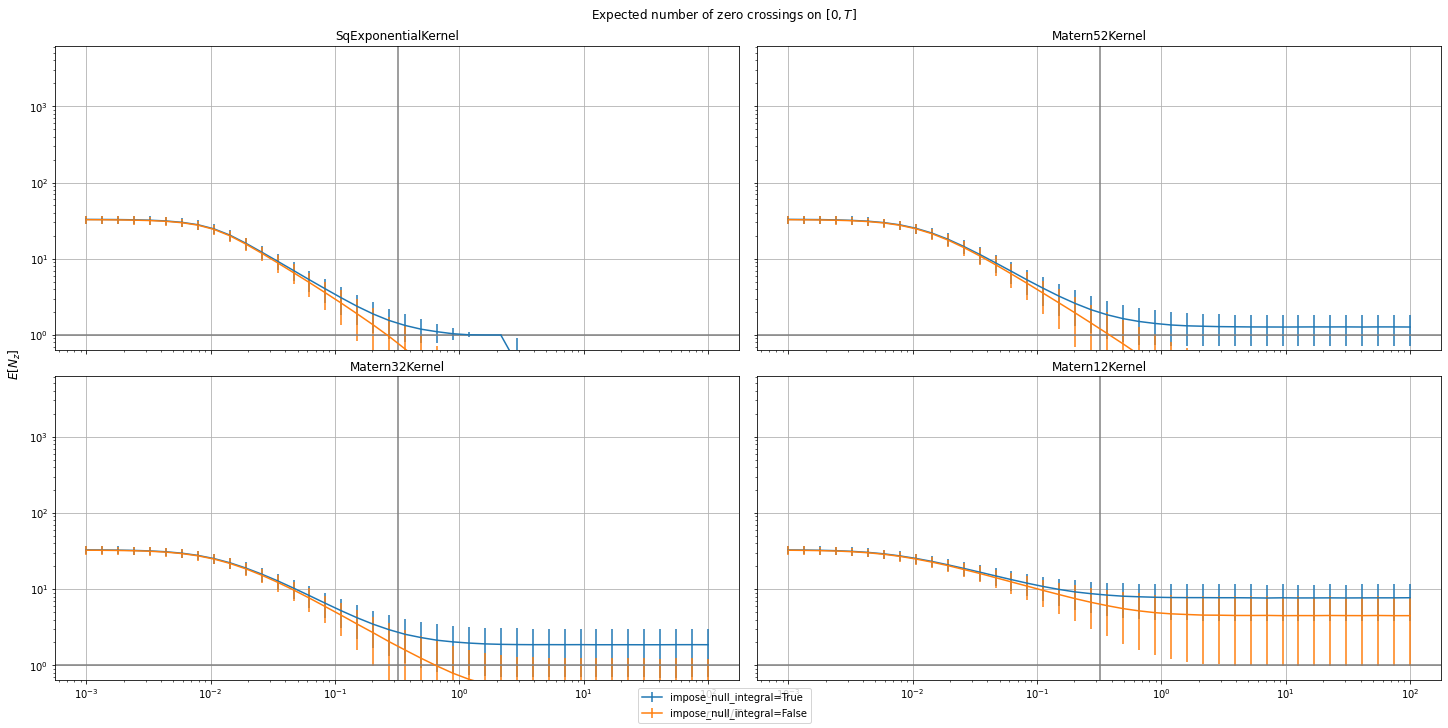

In [46]:
def zero_crossings_hilbert_plot(kernel_name, ax):
    def mean_and_sd(impose_null_integral):
        z = np.vstack([
            num_zero_crossings_dgf(
                sample_hilbert_dgf(kernel_name, r, Nz, impose_null_integral=impose_null_integral)
            ) for r in rs
        ]) # (Nr, Nz)
        m = mean(z, axis=1)
        sd = std(z, axis=1)
        return m, sd
    
    m1, sd1 = mean_and_sd(True)
    m0, sd0 = mean_and_sd(False)
    
    ax.errorbar(rs, m1, yerr=sd1, label='impose_null_integral=True')
    ax.errorbar(rs, m0, yerr=sd0, label='impose_null_integral=False')
    ax.set_title(kernel_name)
    ax.grid()
    
    ax.axvline(1/pi, color='grey')
    ax.axhline(1, color='grey')
    
    return (m0, sd0), (m1, sd1)

fig, axes = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(20,10), constrained_layout=True)
zero_crossings_hilbert_plot('SqExponentialKernel', axes[0,0])
zero_crossings_hilbert_plot('Matern52Kernel', axes[0,1])
zero_crossings_hilbert_plot('Matern32Kernel', axes[1,0])
zero_crossings_hilbert_plot('Matern12Kernel', axes[1,1]);

xscale('log')
yscale('log')
fig.supylabel('$E[N_z]$')
fig.supxlabel('$r = \ell/T$');
suptitle('Expected number of zero crossings on $[0,T]$')

handles, labels = axes[1,1].get_legend_handles_labels() # https://stackoverflow.com/a/46921590/6783015
fig.legend(handles, labels, loc='lower center')

## Determining $r_\max$

In [42]:
Nr = 40
Nz = 100000
rs = 10**linspace(-3, 2, Nr)
energy_nugget = 1e-8

def power_dgf(a):
    return 10*log10(sum(a**2, axis=0)*dx/T)

z = np.vstack([
    power_dgf(sample_exact_dgf(r, Nz, nugget=energy_nugget)) for r in rs
]) # (Nr, Nz)
m = mean(z, axis=1)
sd = std(z, axis=1)

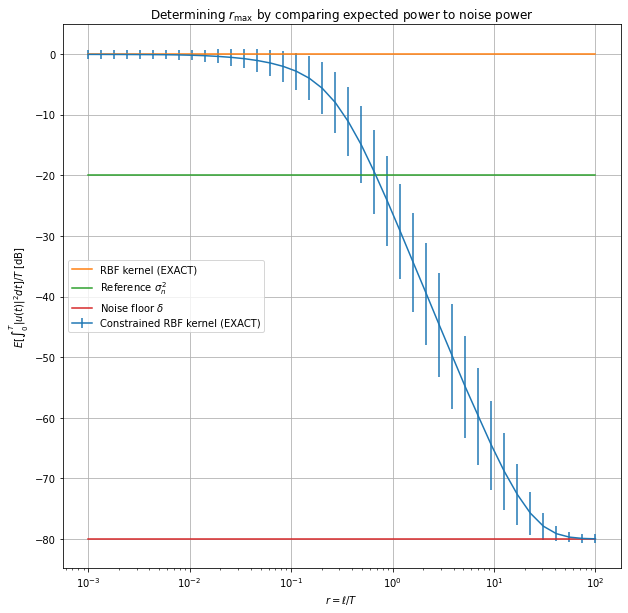

In [45]:
errorbar(rs, m, yerr=sd, label="Constrained RBF kernel (EXACT)")
plot(rs, rs*0., label="RBF kernel (EXACT)")
plot(rs, rs*0. - 20., label="Reference $\sigma_n^2$")

noise_floor_db = (rs*0) + 10*log10(energy_nugget)
plot(rs, noise_floor_db, label='Noise floor $\\delta^2$')

xscale('log')
legend();
grid()
title('Determining $r_{\max}$ by comparing expected power to noise power')
ylabel('$E[\int_0^T |u(t)|^2 dt]/T$ [dB]')
xlabel('$r = \ell/T$');